In [155]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.constants as cnt
from scipy.optimize import curve_fit

In [92]:
folder_path1 = "data/Aufspaltung1_Linie/1Peaks"
folder_path2 = "data/Aufspaltung1_Linie/2Peaks"
files1 = [f for f in os.listdir(folder_path1) if f.endswith('.dat')]
files2 = [f for f in os.listdir(folder_path2) if f.endswith('.dat')]

data1 = {}
data2 = {}

for file in files1:
    file_path = os.path.join(folder_path1, file)
    file_data = np.loadtxt(file_path)
    data1[file.replace('.dat', '').replace('_', '.')] = file_data

for file in files2:
    file_path = os.path.join(folder_path2, file)
    file_data = np.loadtxt(file_path)
    data2[file.replace('.dat', '').replace('_', '.')] = file_data

In [220]:
slope = 0.0010609668109668772
centralwavelength = 585.249

I_to_B = {"0": 0, "0.81": 5, "1.57": 10, "2.28": 15, "3.17": 20, "5.76" : 25}
def steps2lambda(steps):
    return (steps * slope - 919*slope)

def gauss_function(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def centered_gauss(x, a, sigma):
    return gauss_function(x, a, 0, sigma)

def two_gauss_function(x, a, width, sigma):
    return gauss_function(x, a, -width, sigma) + gauss_function(x, a, width, sigma)

def gauss_area(a, sigma):
    return a * np.sqrt( 2 * np.pi * np.abs(sigma))

B =0.0T Area1 55.365394384198765, Area2 73.91733264909217
B =0.5T Area1 58.66520928787872, Area2 86.45839864166435
B =1.0T Area1 57.070093592510325, Area2 85.79971050539675
B =1.5T Area1 55.96656509563462, Area2 89.4796397206059
B =2.0T Area1 35.44321811322992, Area2 57.19674874418506
B =2.5T Area1 34.03843336359341, Area2 54.1869678217639


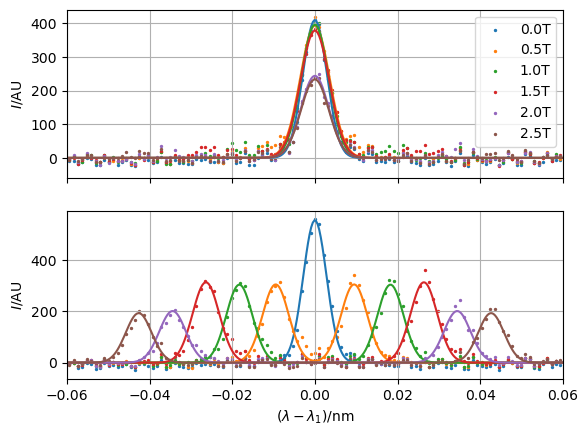

In [223]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
width = .06
ax1.grid()
ax2.grid()
background = 250
offsets = [0, 0.01, 0.02, 0.028, 0.032,0.042]
offsets_measured = []
magnetic_fields = []
for i, B in enumerate(data1):
    lambdas = steps2lambda(data1[B][:, 0])
    inten1 = data1[B][:, 1] - background
    inten2 = data2[B][:, 1] - background

    left, right = (np.argmin(np.abs(lambdas + width)), np.argmin(np.abs(lambdas - width)))

    p0 = [inten1.max(), 0.1]
    coeff1, _ = curve_fit(centered_gauss, lambdas[left:right], inten1[left:right], p0=p0, maxfev=10000)
    coeff2, _ = curve_fit(two_gauss_function, lambdas[left:right], inten2[left:right], p0=[inten2.max() / 5, offsets[i], 1e-3], maxfev=100000)
    offsets_measured.append(coeff2[1])
    magnetic_fields.append(I_to_B[B] / 10)

    print(f'B ={I_to_B[B] / 10}T Area1 {gauss_area(coeff1[0], coeff1[1])}, Area2 {2 * gauss_area(coeff2[0], coeff2[2])}')
    ax1.scatter(lambdas, inten1, 2, label=f'{I_to_B[B]/10}T')

    lambdas_plot = np.linspace(min(lambdas), max(lambdas), 10000)
    ax1.plot(lambdas_plot, centered_gauss(lambdas_plot, *coeff1))
    ax2.scatter(lambdas, inten2, 2,  label=f'{I_to_B[B]/10}T')
    ax2.plot(lambdas_plot, two_gauss_function(lambdas_plot, *coeff2))
ax1.set(ylabel="$I / \\mathrm{AU}$")
ax2.set(xlim=[-width, width], xlabel='$ (\\lambda - \\lambda_1) / \\mathrm{nm}$', ylabel="$I / \\mathrm{AU}$")
ax1.legend()
fig.savefig('out/zeeman_splitting')

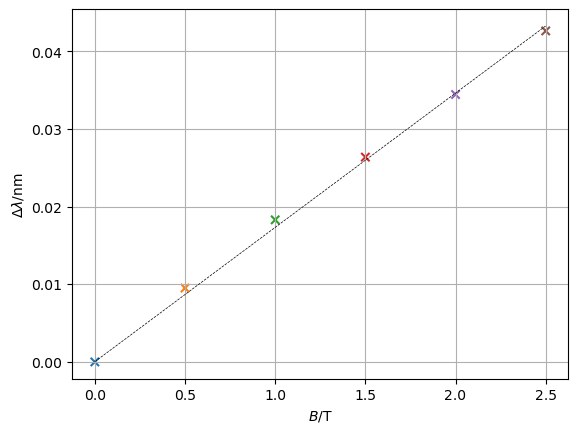

In [229]:
fig2, ax3 = plt.subplots()
ax3.scatter(magnetic_fields, offsets_measured, marker='x', c=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'])
def lin_func(x, a):
    return x*a


coeff3, _ = curve_fit(lin_func, magnetic_fields, offsets_measured)
bs = np.linspace(min(magnetic_fields), max(magnetic_fields), 100)
ax3.plot(bs, lin_func(bs, *coeff3), 'k--', lw=0.5)
ax3.set(xlabel="$B / \\mathrm{T}$", ylabel="$\\Delta \lambda/ \\mathrm{nm}$")
ax3.grid()
fig2.savefig('out/e_m_lin_reg')

6.1556652429990384e+32

In [186]:
e_m = (4 * np.pi * cnt.c) / ((centralwavelength* 1e-9)**2 * 1.034) * coeff3[0]*1e-9
print(f"e/m_e = {e_m:.3e}")

e/m_e = 1.838e+11


In [188]:
e_m_theo = cnt.e / cnt.m_e
(e_m_theo - e_m )/ e_m_theo * 100

-4.51074486584899